# Setup

In [1]:
# Setting up google drive 
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
import sys
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks')

In [ ]:
#from google.colab import files               #Assuming you've uploaded the my_utils file once, This isn't necessary
#src = list(files.upload().values())[0]
#open('my_utils.py','wb').write(src)

In [2]:
import my_utils as mu
import torch
from torch import nn
from IPython import display

# Defining the Model
* Creates a neural network to accept the number of inputs, outputs and backbone layers.


In [3]:
class Net(torch.nn.Module):        
    def __init__(self, num_inputs, num_outputs,num_backbone,num_hidden):
        super(Net, self).__init__()
        self.num_inputs = num_inputs;
        self.num_outputs = num_outputs;
        self.num_backbone = num_backbone;
        previous=int(((num_inputs)**0.5)/2+1)**2;#the count of outputs into the first linear layer
        total_nodes=num_backbone*3+3;#the count of linear layers
        layer_neurons=[previous]+[num_hidden]*(total_nodes-1)+[num_outputs]#generates the number of outputs inbetween any 2 layers
        print(layer_neurons);
        #Add stem
        self.stem_pool = nn.AvgPool2d((2, 2), stride=(2, 2),padding=(1,1),count_include_pad=False);
        self.stem_fltn = nn.Flatten();
        k=0;#counter variable used to traverse layer_neurons
        for i in range(0,num_backbone):#Add backbone
            self.add_module('BBlayer{0}LinearA'.format(i), nn.Linear(layer_neurons[k],  layer_neurons[k+1], bias=True));
            k+=1;
            self.add_module('BBlayer{0}LinearB'.format(i), nn.Linear(layer_neurons[k],  layer_neurons[k+1], bias=True));
            k+=1;
            self.add_module('BBlayer{0}LinearC'.format(i), nn.Linear(layer_neurons[k],  layer_neurons[k+1], bias=True));
            k+=1;
            self.add_module('BBlayer{0}norm'.format(i), nn.BatchNorm1d(layer_neurons[k],affine=True));
        #Add classifier
        self.add_module('classifierA', nn.Linear(layer_neurons[k],  layer_neurons[k+1], bias=True))
        k+=1;
        self.add_module('classifierB', nn.Linear(layer_neurons[k],  layer_neurons[k+1], bias=False))
        k+=1;
        self.add_module('classifierC', nn.Linear(layer_neurons[k],  layer_neurons[k+1], bias=False))
    def forward(self, x):
        out=x
        #Apply stem
        out = self.stem_pool(out);
        out = self.stem_fltn(out);
        for i in range(0,num_backbone):#Apply BackBone
            out = self._modules['BBlayer{0}LinearA'.format(i)](out)
            out = nn.functional.silu(out);
            out = self._modules['BBlayer{0}LinearB'.format(i)](out)
            out = nn.functional.selu(out);
            out = self._modules['BBlayer{0}LinearC'.format(i)](out)
            out = self._modules['BBlayer{0}norm'.format(i)](out)
            out = nn.functional.celu(out);
        #Apply Classifier
        out = self._modules['classifierA'](out);
        out = nn.functional.silu(out);
        out = self._modules['classifierB'](out);
        out = nn.functional.relu(out);
        out = self._modules['classifierC'](out);
        out = nn.functional.relu6(out);
        return out;

# Weight Initialization

In [4]:
def init_weights(m):#called once in each layer, checks if layertype==Linear, then initializes it to default values
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight) 

# Training

* The training function was rewritten from the myutils default to allow for a scheduler, and an animator with different limits.
* Each epoch, the test accuracy is printed numerically and the updated graph is displayed beneath.

In [5]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs,optimizer,decay_rate): 
    animator =mu.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.0, 1.0],
                          legend=['train loss', 'train acc', 'test acc']);#Displays graph of progress
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=decay_rate);#each time the scheduler is stepped, multiplies learning rate by decay_rate (~0.97)
    for epoch in range(num_epochs):
        train_metrics = mu.train_epoch_ch3(net, train_iter, loss, optimizer);
        test_acc = mu.evaluate_accuracy(net, test_iter);
        print(test_acc);#Prints the numeric test accuracy above the graph
        animator.add(epoch + 1, train_metrics + (test_acc,));
        scheduler.step();

# Main
* Assigns hyper-parameters, and initializes the weights.
* Finally it starts he network training, before evaluating its success

In [6]:
num_inputs, num_outputs, num_hidden = 784, 10, 450;
num_backbone=5;
num_epochs = 100;
batch_size = 256;
learning_rate=1e-4;
decay_rate=0.05**(1/num_epochs);#will decay learning rate to 0.05 of the original value over all epochs
train_iter, test_iter = mu.load_data_fashion_mnist(batch_size)
loss = nn.CrossEntropyLoss() #Default function for getting cross entropy loss, which I should examine more.
print(len(train_iter),len(test_iter))
net = Net(num_inputs, num_outputs,num_backbone, num_hidden)
net.apply(init_weights); #applies the init_weights function to each layer
optimizer = torch.optim.AdamW(net.parameters(), lr=learning_rate)

235 40
[225, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 10]


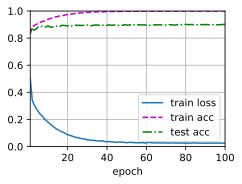

In [7]:
print("Starting training");
train_ch3(net, train_iter, test_iter, loss, num_epochs, optimizer, decay_rate)

In [8]:
print(mu.evaluate_accuracy(net,test_iter))#Final training accuracy
print(net);#Displays components of net, which happen to be used in order

0.9018
Net(
  (stem_pool): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
  (stem_fltn): Flatten(start_dim=1, end_dim=-1)
  (BBlayer0LinearA): Linear(in_features=225, out_features=450, bias=True)
  (BBlayer0LinearB): Linear(in_features=450, out_features=450, bias=True)
  (BBlayer0LinearC): Linear(in_features=450, out_features=450, bias=True)
  (BBlayer0norm): BatchNorm1d(450, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BBlayer1LinearA): Linear(in_features=450, out_features=450, bias=True)
  (BBlayer1LinearB): Linear(in_features=450, out_features=450, bias=True)
  (BBlayer1LinearC): Linear(in_features=450, out_features=450, bias=True)
  (BBlayer1norm): BatchNorm1d(450, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BBlayer2LinearA): Linear(in_features=450, out_features=450, bias=True)
  (BBlayer2LinearB): Linear(in_features=450, out_features=450, bias=True)
  (BBlayer2LinearC): Linear(in_features=450, out_features=450, bias=True)
